### Regressions

In [1]:
#import necessary libraries for regression analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.style.use('bmh')

from statsmodels.formula.api import ols
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import scipy.stats as stats
from sklearn.model_selection import train_test_split

#Import custom functions 
import pylab
from modelCustomFunctions import create_ols, check_resid_distribution, check_features_vif, get_low_pval_features

#Import library with additional data for US Zip Codes
import uszipcode


## Additional EDA

Before we build our first regression model, we are going to explore the data some more. 

In [2]:
#Load the CSV containing our cleaned data 
df = pd.read_csv('Cleaned_Data_w_Outliers', index_col=0)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,renovated
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,1340,5650,0
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,1690,7639,0
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,2720,8062,0
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,1360,5000,0
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,1800,7503,0


We will create some boxplots to visualize potential outliers in some of our variables. The most common characteristics of a house are its square footage and # of bedrooms/bathrooms. We'll explore the values in those three categories and the values in our dependent variable, **price**. 

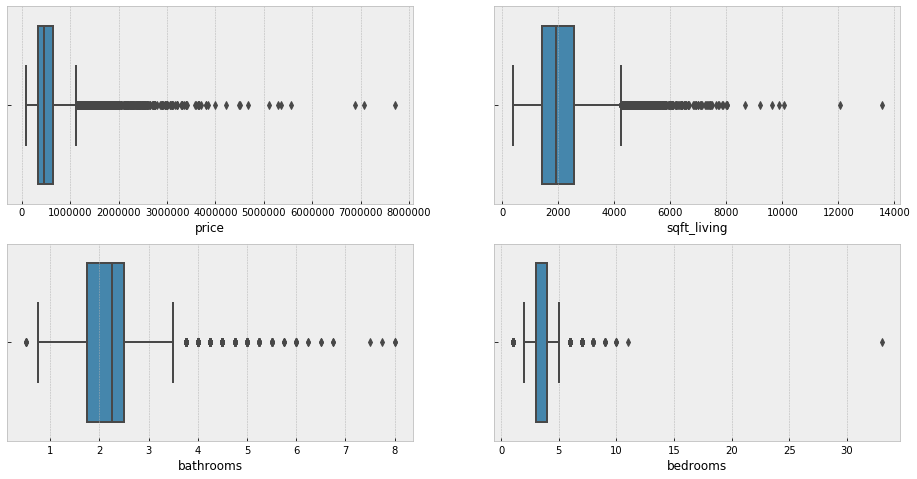

In [3]:
#Create boxplots to identify outliers
plt.figure(figsize=(16,8))
plt.subplot(221)
sns.boxplot(x=df['price'])
plt.subplot(222)
sns.boxplot(x=df['sqft_living'])
plt.subplot(223)
sns.boxplot(x=df['bathrooms'])
plt.subplot(224)
sns.boxplot(x=df['bedrooms'])


There are a few expensive homes included in our data set. We will remove all homes that sold for more than $700,000 as we expect our model to predict prices in the higher range less accurately. We will also remove all homes with more than 13 bedrooms, which will take care of the house with 33 bedrooms (most likely a human error since it's less than 2000 sqft). Additionally, we are removing homes larger than 11,000 sqft. Again, our model will probably not be the most suitable for evaluating mansion-like properties.

In [4]:
#Remove outliers
df = df[df["price"] < 700000]
df = df[df["bedrooms"] < 13]
df = df[df["sqft_living"] < 11000]

In [5]:
#Let's see how many data entries we are left with. 
df.shape

(17024, 18)

In [6]:
#One last check of variable statistics before we proceed
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,renovated
count,17024.000000,17024.000000,17024.000000,17024.000000,1.702400e+04,17024.000000,17024.000000,17024.000000,17024.000000,17024.000000,17024.000000,17024.000000,17024.000000,17024.000000,17024.000000,17024.000000,17024.000000,17024.000000
mean,408910.717575,3.242540,1.955607,1812.437617,1.324019e+04,1.435180,0.001527,0.115425,3.398907,7.316906,1571.748414,235.516859,1970.538828,49.523731,98079.274847,1803.821194,11744.691318,0.015684
std,138217.605015,0.861615,0.668283,650.700305,3.300909e+04,0.535977,0.039051,0.514502,0.640064,0.870290,609.469721,375.915013,28.444575,310.269974,53.798503,510.753087,24302.531878,0.158344
min,78000.000000,1.000000,0.500000,370.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,399.000000,651.000000,0.000000
25%,299000.000000,3.000000,1.500000,1330.000000,5.000000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1130.000000,0.000000,1952.000000,0.000000,98033.000000,1430.000000,5034.500000,0.000000
50%,399900.000000,3.000000,2.000000,1730.000000,7.434000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1420.000000,0.000000,1973.000000,0.000000,98065.000000,1720.000000,7500.000000,0.000000
75%,517000.000000,4.000000,2.500000,2210.000000,1.000000e+04,2.000000,0.000000,0.000000,4.000000,8.000000,1890.000000,450.000000,1994.000000,0.000000,98118.000000,2120.000000,9622.250000,0.000000
max,699999.000000,11.000000,7.500000,5461.000000,1.164794e+06,3.500000,1.000000,4.000000,5.000000,11.000000,5450.000000,2196.000000,2015.000000,2015.000000,98199.000000,4410.000000,438213.000000,2.000000


Lastly, we want to get a sense of each column's unique values to get an idea of whether we want to transform any variables by binning them (similarly to yr_renovated --> renovated) at this stage.

In [7]:
df.nunique() #looking at unique values in each column

price            2689
bedrooms           11
bathrooms          22
sqft_living       781
sqft_lot         8021
floors              6
waterfront          2
view                5
condition           5
grade               9
sqft_above        730
sqft_basement     236
yr_built          116
yr_renovated       69
zipcode            69
sqft_living15     616
sqft_lot15       7106
renovated           3
dtype: int64

From the categorical variables we have (bedrooms, bathrooms, floors, waterfront, view, condition, grade, renovated), it looks like we can potentially bin bedrooms, bathrooms, and grade. However, we are curious to see how these will impact our baseline mode in their current format.

### Assumptions Check: Linearity and Multicolinearity

We want to check the regression assumptions for linearity and multicollinearity before we build our baseline model. We cannot check the other assumptions at this stage as we don't have any residuals to work with. 

In [8]:
#Defining our target and features 
target = "price"
features = list(df.columns)
features.remove(target)

First, we will create a heatmap to see how features are correlated with each other and with our target variable. We will then do an additional check for multicollinearity by getting the variance inflation factor (VIF) for each feature. The ones with a high VIF will be removed from the feature set. 

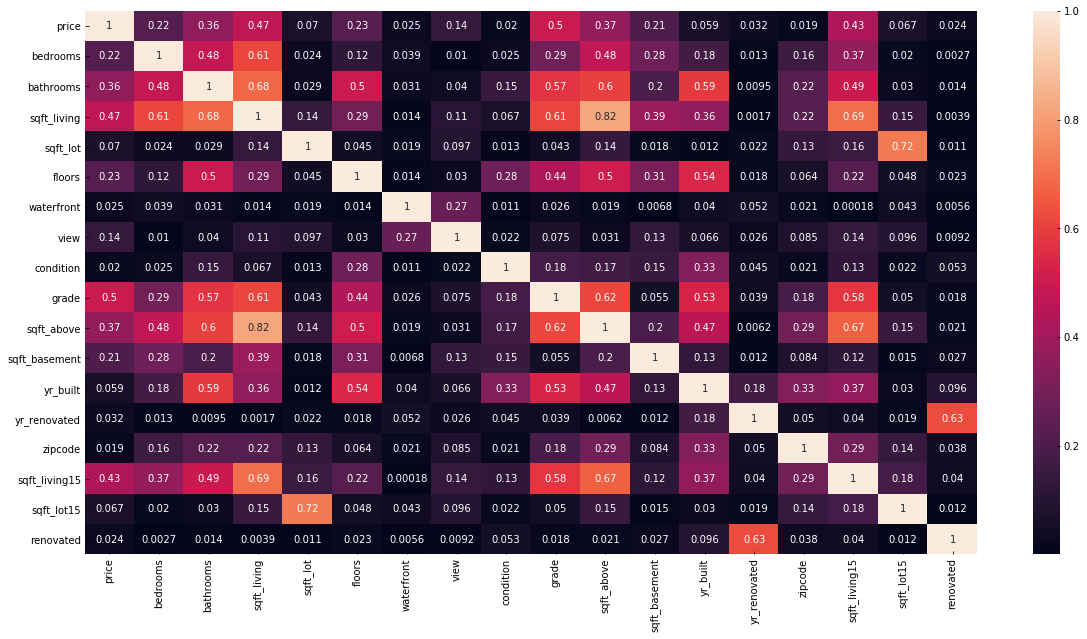

In [9]:
#explore features with high correlation 
corr = df.corr().abs()
plt.figure(figsize=(20,10))
ax = sns.heatmap(corr, annot=True) 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [10]:
#Check Multicolinearity with VIF

check_features_vif(df, target)

,VIF Factor,features
0,26.3,bedrooms
1,27.8,bathrooms
2,875.4,sqft_living
3,2.4,sqft_lot
4,16.5,floors
5,1.1,waterfront
6,1.2,view
7,34.4,condition
8,155.7,grade
9,665.1,sqft_above


['sqft_living',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'zipcode',
 'sqft_living15']

Our function returns a list of features with a VIF higher than 30. We will drop **grade** now because it seems correlated with the condition. Since both features describe the home's quality, we believe the condition is the more relevant and impactful predictor. We are keeping **sqft_living** and **sqft_lot** because we expect their VIF factor to decrease after getting rid of all other sqft-related variables. 

In [11]:
df = df.drop(columns = ['yr_built','sqft_above','sqft_basement','sqft_living15', 'sqft_lot15', 'grade'])

In [12]:
#Let's check how the VIFs of the remaining variables have changed
check_features_vif(df, target)

,VIF Factor,features
0,25.6,bedrooms
1,22.6,bathrooms
2,21.3,sqft_living
3,1.2,sqft_lot
4,11.9,floors
5,1.1,waterfront
6,1.2,view
7,32.0,condition
8,1.7,yr_renovated
9,58.2,zipcode


['condition', 'zipcode']

Zipcode still shows a slighly higher VIF than what we want to see. However, it is one of the most essential predictors for our model and our business case so we are keeping it for now. 

## Check for Normality 

We want to check if there continuous variables **"sqft_living" and "sqft_lot"** have a linear relationship with our target variable **price**. 

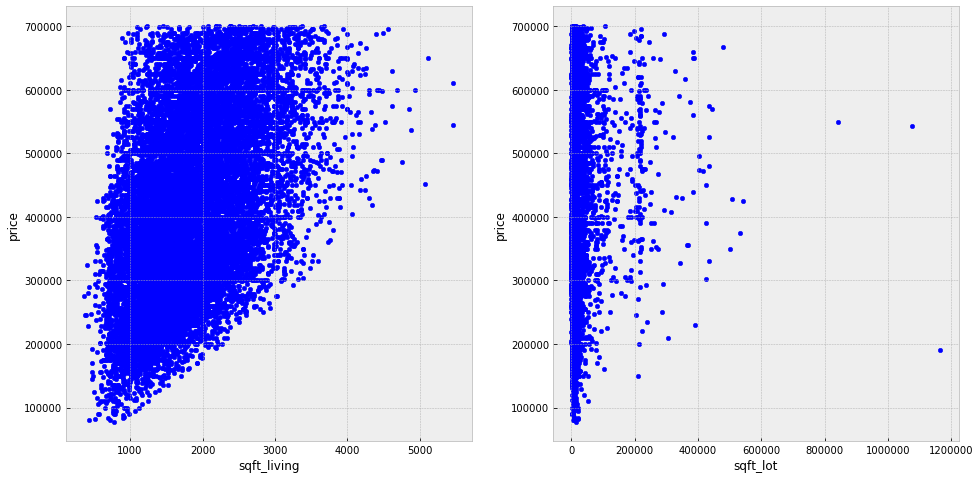

In [13]:
#Create scatter plots to visualize the relationships
fig, axs = plt.subplots(1, 2)
df.plot(kind='scatter', x='sqft_living', y='price', ax=axs[0], figsize=(16, 8))
df.plot(kind='scatter', x='sqft_lot', y='price', ax=axs[1])


It looks like the price goes up as the house's size increases, which is totally expected. There's less of a linear relationship between sqft_lot and price.

## Custom Functions to Test Assumptions

We add two additional functions that will help us test for homoscedasticity and residuals' distribution faster as we iterate through our models. 

In [14]:
def check_homoskedasticity(model, df, target : "", features):
    
    """Inputs: 
    model: an sm.OLS model  
    df: a data frame
    target : a string 
    features: the features of the model 
    
    Retruns: 
    True if there's probable homoskedasticity
    False if there's probable skedasticity 
    Prints out P-value and F-statistic
    ------------------------
    Uses the Breusch–Pagan test. If p-value is below 0.05, then 
    the null hypothesis of homoskedasticity is rejected and 
    heteroskedasticity is assumed.
    """ 
    
    #Plot scatter plot
    y_hat = df[target] - model.predict(df[features])
            
    plt.scatter(model.predict(df[features]), y_hat, alpha = 0.2)
    plt.plot(model.predict(df[features]), [0 for i in range(len(df))])
    plt.show()

    #run Pegan test
    _, pval, _, f_pval = diag.het_breuschpagan(model.resid, model.model.exog)
    
    print('-'*50)
    print('The P-value is: {:.2}'.format(pval))
    print('The F-statistic is {:.2}'.format(f_pval))
    print('-'*50)
    
    if pval >= 0.05:
    
        print("The p-value is above 0.05, thus we fail to reject the null hypothesis of homoskedasticity")
        return True

    return False

In [15]:
def check_residuals(df, target, features, model):
    
    y_observed = df[target]
    y_hat = model.predict(df[features])
    residuals = model.resid
    # Plot scatter for Observed values vs predicted values
    sns.scatterplot(y_observed, y_hat)
    plt.title('Predictions')
    plt.xlabel('y_observed')
    plt.ylabel('y_hat')
    plt.show()
    
    # Check homoskedasticity with a scatter plot
    x_axis = np.linspace(0,1,len(residuals))
    sns.scatterplot(x_axis, residuals)
    plt.hlines(y=0, xmin=0, xmax=1, color='red')
    plt.title('Check for Homoskedasticity')
    plt.ylabel('Residuals')
    plt.show()
    
    # Plot the distribution of residuals
    sns.histplot(residuals)
    plt.title('Distribution of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()
    
    # Check Residuals distribution wiht QQPlot
    # Get exact Mean of Residuals
    check_resid_distribution(model)
    
    #Print RMSE
    print(f"Average error by: $ {round(residuals.abs().mean(),2)}")

## Baseline Model

We proceed building our baseline model which includes ten predictors: bedrooms, bathroom, sqft living, sqft lot, floors, waterfront, view, condition, yr_renovated, zipcode, condition and renovated. 

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
#Build the first model and looking at its summar table
baseline = create_ols(df, target)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     569.0
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        10:00:48   Log-Likelihood:            -2.2299e+05
No. Observations:               17024   AIC:                         4.460e+05
Df Residuals:                   17012   BIC:                         4.461e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -3.231e+07   1.73e+06    -18.634   

**Quick interpretation:** The model in its current version yields a pretty inaccurate estimation of price, with an R-squared of 0.269. The p-values for most of our features look good except for waterfront and yr_renovated (>0.05). The coefficient for sqft_living confirms that this is a significant predictor as a house's price goes up by 101 dollars per sqft. The median price for each square foot for a home in the United States is 123 dollars per sqft. The other coefficients are less useful at the moment as most of the variables are categorical. We see that the most significant impact on price from one category to another is zip codes.

Let's check some assumptions.

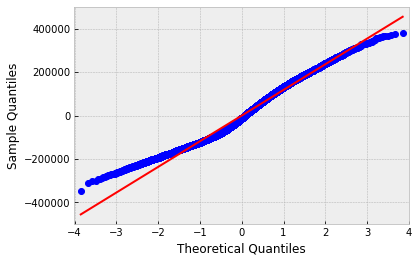

The mean of the residuals is: 7.9e-07. The closer to 0, the better.


In [18]:
#check the distirbution of the residuals
check_resid_distribution(baseline)

At the moment, our residuals don't hug the line the way we want them to. Their mean is also not as close to 0 as we would like.

Next, let's test for homoscedasticity. We are looking to see if we have an even variance across the error terms.

In [19]:
#Making sure we have the right features for our function to work
features = list(df.columns)
features.remove(target)

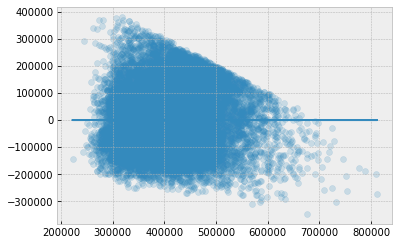

--------------------------------------------------
The P-value is: 4.1e-22
The F-statistic is 3.4e-22
--------------------------------------------------


False

In [20]:
check_homoskedasticity(baseline, df ,target, features)

Based on the Breusch–Pagan test and on what we see in the scatter plot above, there's defintely probable heteroscedasticity. This is another probelm with our current model.

### Model 2 

To improve on our baseline, we'll start by engineering some additional features that will quantify the value of zip codes a bit better. 

##### Feature engineering

The first new feature we are adding is the median household income for each zip code. Household finance experts assert that buyers can afford to pay up to three times their annual incomes for a home.

In [21]:
#Average (median) Household Income per zip code
search = uszipcode.SearchEngine()
def zip_income(x):
    income = search.by_zipcode(x).median_household_income
    return income if income else x 

df['avg_income_zip'] = df.zipcode.apply(zip_income)

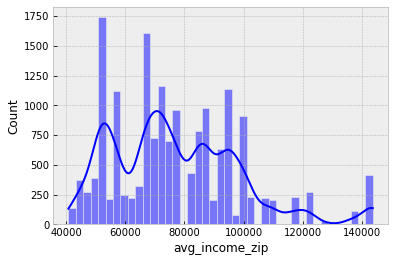

In [22]:
#Preview distribution for the new feature
sns.histplot(df.avg_income_zip, kde=True)

The second feature we are adding is the **population density for each zip code**. We assume that zip codes with higher population density are more desirable and prices are higher than in zip codes with lower density.

In [23]:
#Population density for zip codes
def population_density(x):
    density = search.by_zipcode(x).population_density
    return density if density else x

df['zip_population_density'] = df.zipcode.apply(population_density)

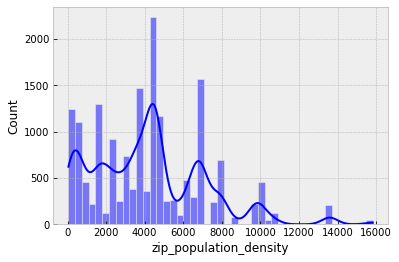

In [24]:
#Preview distribution for the new feature
sns.histplot(df.zip_population_density, kde=True)

In [25]:
#making sure everything looks with our data before we proceed with model 2
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,yr_renovated,zipcode,renovated,avg_income_zip,zip_population_density
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,0.0,98178,0,58707,4966.0
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,1991.0,98125,0,53044,6879.0
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,0.0,98028,0,82448,3606.0
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,0.0,98136,0,84344,6425.0
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,0.0,98074,0,143686,2411.0


In [26]:
#Also, let's drop the yr_renoavted column since it has a p-value over 0.05
df = df.drop(columns = ['yr_renovated'])

### Model 2

We've expanded the feature set by adding avg_income_zip and zip_population which we believe are meaningful predictors for a home's price.

In [27]:
model2 = create_ols(df, target)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     2190.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        10:01:25   Log-Likelihood:            -2.1771e+05
No. Observations:               17024   AIC:                         4.354e+05
Df Residuals:                   17011   BIC:                         4.355e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.49

We are making some progress. Adding the new features more than doubled our R-squared. We only have one more variable with a p-value over 0.05. Additionally, we see some strange coefficients for bedrooms (-8,453) and floors.  

Let's test the assumptions again.

The distribution of our residuals is way more normal, with a mean closer to 0.

In [28]:
features2 = list(df.columns)
features2.remove(target)

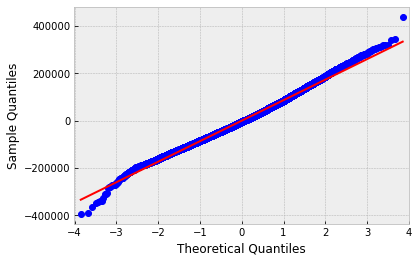

The mean of the residuals is: 7.6e-08. The closer to 0, the better.


In [29]:
check_resid_distribution(model2)

The distribution of our residuals is way more normal, with a mean closer to 0.

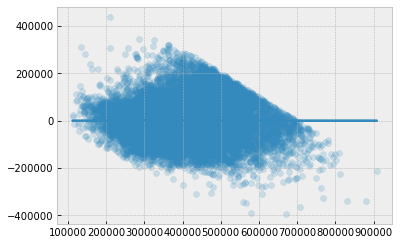

--------------------------------------------------
The P-value is: 2e-104
The F-statistic is 4.1e-106
--------------------------------------------------


False

In [30]:
check_homoskedasticity(model2, df, target, features2)

We see some improvement in terms of homoscedasticity, but unfortunately we are still presuming heteroscedasticity.

### Model 3

Let's start wokring on our next iteration. We are looking to do some additional data transformations to improve the model and hopefully take of our heteroscedasticity problem. 

In [31]:
#Let's take a look at our features once again
features

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'yr_renovated',
 'zipcode',
 'renovated']

Continuous variables: 'sqft_living', 'sqft_lot', 'price'

(0, 10000)

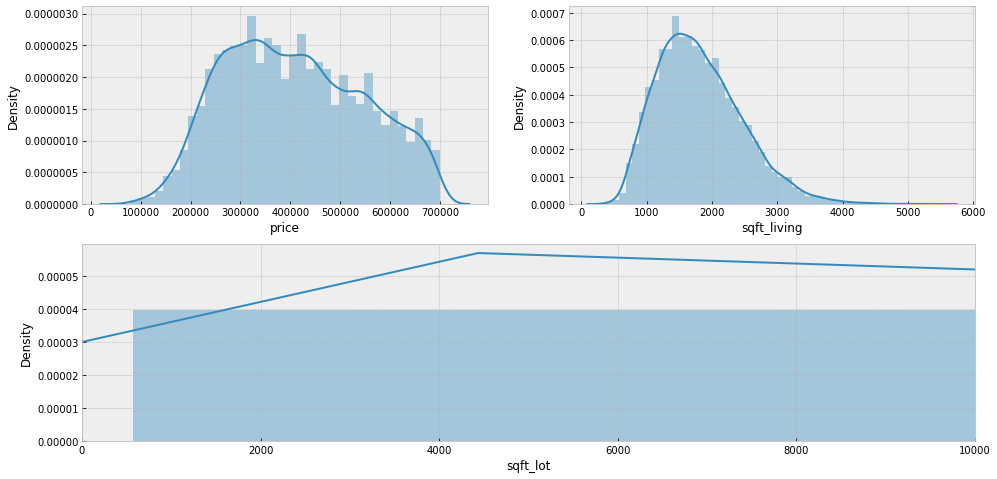

In [32]:
#Exploring distributions of continuous variables
plt.figure(figsize=(16,8))
plt.subplot(221)
sns.distplot(df.price, label='Prices')
plt.subplot(222)
sns.distplot(df.sqft_living, label='Sqft Living')
plt.subplot(212)
sns.distplot(df.sqft_lot, label='Sqft Lot')
plt.xlim(0, 10000)

Our continuous variables currently don't follow a normal distribution. Sqft_living seems pretty skewed, so logging it might improve our heteroscedasticity. 

In [33]:
# Convert to logs
price = np.log(df.price)
sqft_living = np.log(df.sqft_living)
sqft_lot = np.log(df.sqft_lot)

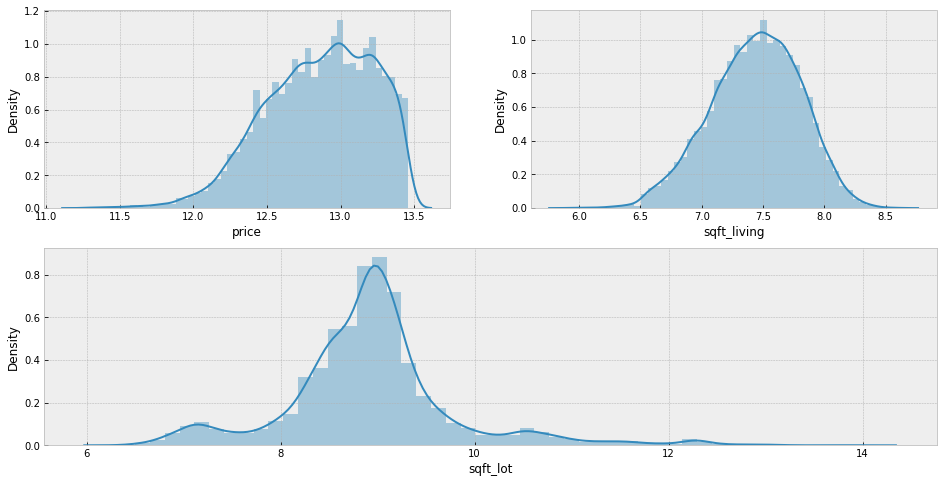

In [34]:
#Comparing the distributions
plt.figure(figsize=(16,8))
plt.subplot(221)
sns.distplot(price, label='Prices')
plt.subplot(222)
sns.distplot(sqft_living, label='Sqft Living')
plt.subplot(212)
sns.distplot(sqft_lot, label='Sqft Lot')

The distributions for sqft_living and sqft_lot definitely look more normal after the log transformation. We also see a small improvement in price; however, we won't implement the log transformation on the price to our data frame. We don't believe the improvement is significant enough.

In [35]:
#Apply log transformations


df['sqft_living'] = sqft_living
df['sqft_lot'] =sqft_lot

Let's build our new mode with the log-transormed sqft_living and sqft_lot

In [36]:
model3 = create_ols(df,target)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     2209.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        10:01:27   Log-Likelihood:            -2.1767e+05
No. Observations:               17024   AIC:                         4.354e+05
Df Residuals:                   17011   BIC:                         4.355e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.89

A very slight improvement of R-squared. All p-values look great. 

In [37]:
features3 = list(df.columns)
features3.remove(target)

Let's check for both normality and homoskedasticity at the same time. Also, let's see what our RMSE looks like at this stage to evaluate our model further.

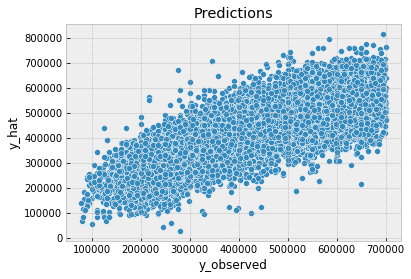

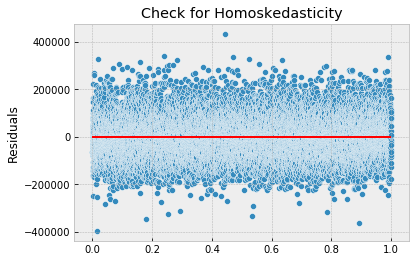

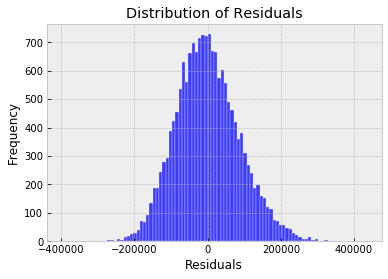

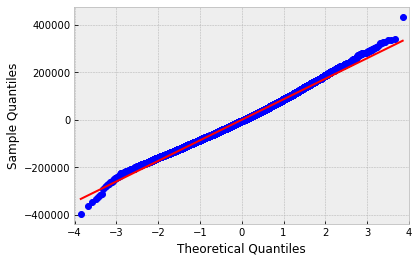

The mean of the residuals is: 1.4e-06. The closer to 0, the better.
Average error by: $ 68448.21


In [38]:
check_residuals(df, target, features3, model3 )

The distribution of residuals looks even better and more normal than in the previous two versions of the model. We are almost at 0 for the mean of our residuals. 

Based on the graph above, we can also presume homoskedasticity.

Lastly, our model is doing a pretty decent job at predicting prices, with an average error of $68,448.21

### Model 4

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17024 entries, 0 to 21596
Data columns (total 13 columns):
price                     17024 non-null float64
bedrooms                  17024 non-null int64
bathrooms                 17024 non-null float64
sqft_living               17024 non-null float64
sqft_lot                  17024 non-null float64
floors                    17024 non-null float64
waterfront                17024 non-null float64
view                      17024 non-null float64
condition                 17024 non-null int64
zipcode                   17024 non-null int64
renovated                 17024 non-null int64
avg_income_zip            17024 non-null int64
zip_population_density    17024 non-null float64
dtypes: float64(8), int64(5)
memory usage: 1.8 MB


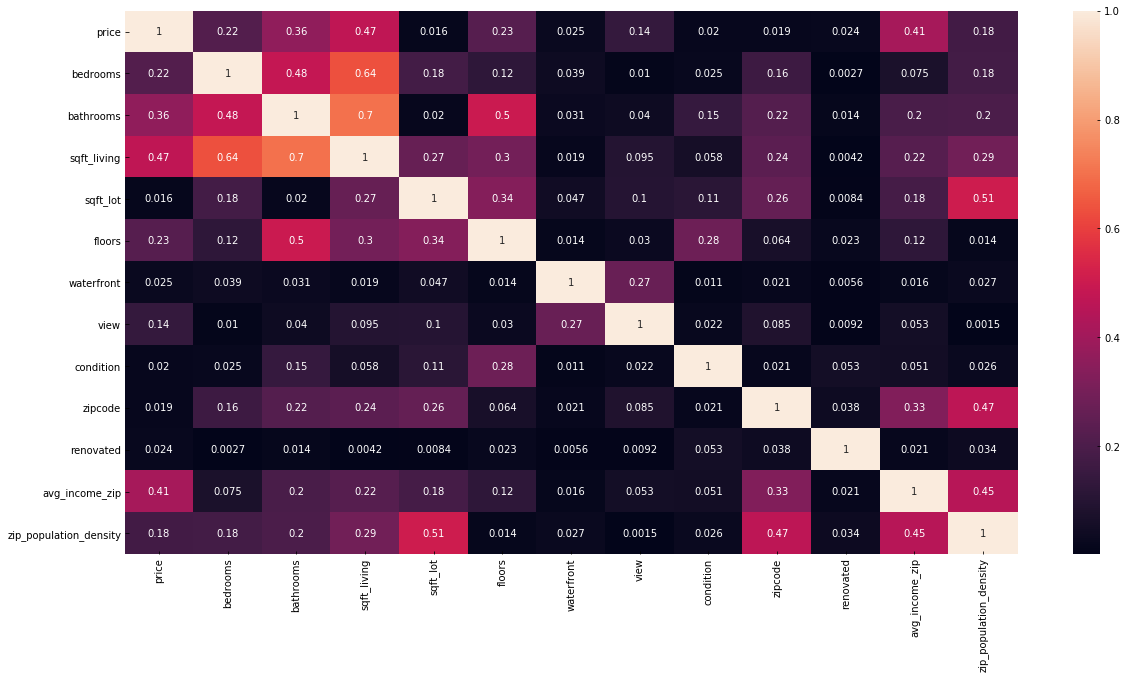

In [40]:
corr2 = df.corr().abs()
plt.figure(figsize=(20,10))
ax = sns.heatmap(corr2, annot=True) 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [41]:
#Drop renovated, waterfront and sqft_lot as they either have low correlation with our target
#variable or have high correlation with other features
df6 = df.drop(columns=['waterfront','sqft_lot', 'renovated'])

We want to express zip code as a more meaningful variable so we will replace it with the name of the city.

In [42]:
def city_name(x):
    city = search.by_zipcode(x).city
    return city if city else x 

df6['city'] = df6.zipcode.apply(city_name)

In [43]:
df6.city.value_counts()

Seattle          7189
Renton           1487
Kent             1184
Auburn            896
Federal Way       762
Kirkland          707
Bellevue          615
Redmond           593
Maple Valley      569
Issaquah          552
Sammamish         415
Woodinville       333
Kenmore           270
Snoqualmie        269
Enumclaw          228
North Bend        200
Duvall            186
Bothell           182
Carnation         109
Vashon            102
Black Diamond      88
Fall City          58
Mercer Island      30
Name: city, dtype: int64

Since our regression model doesn't work with strings, we need to transform this new categorical variable. We'll create dummies to make the feature more useful for our model.

In [44]:
df6.city = df6.city.astype('category')
city = pd.get_dummies(df6.city, prefix='city')
df_new = pd.concat([df6, city], axis=1)

We no longer need zip code and city as variables, and instead of dropping the first dummy, we are dropping the one with the highest frequency and the one that makes the most sense as a baseline for coefficient interpretation - Seattle. 

In [45]:
df_new = df_new.drop(columns = ['zipcode','city','city_Seattle'])

We noticed that not all columns are formatted properly, which caused some issues with our OLS formula. So let's fix that.

In [49]:
subs = [(' ','_')]
def col_formatting(col):
    for old, new in subs:
        col = col.replace(old,new)
    return col

df_new.columns = [col_formatting(col) for col in df_new.columns]

In [50]:
model4 = create_ols(df_new,target)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     1245.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        10:01:48   Log-Likelihood:            -2.1577e+05
No. Observations:               17024   AIC:                         4.316e+05
Df Residuals:                   16993   BIC:                         4.318e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.48

Our R-squared went up again: it now explains about 68.7% of our data variance. We have a few p-values over our 0.05 threshhold and we'll drop them before we test the assumptions and move to the next iteration. Our bathroom and floor coefficients look quite high. Looking at the coefficients for cities, compared to the baseline Seattle, things make sense. For example, prices in Black Diamond, Bellevue and Mercer Island go up compared to Seattle. 

In [51]:
#drop features with high p-values
df_new2 = df_new.drop(columns=['city_Black_Diamond','city_Duvall', 'city_Carnation', 'city_Enumclaw'])

In [52]:
model5 = create_ols(df_new2,target)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     1436.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        10:01:48   Log-Likelihood:            -2.1577e+05
No. Observations:               17024   AIC:                         4.316e+05
Df Residuals:                   16997   BIC:                         4.318e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.48

In [53]:
features5 = list(df_new2.columns)
features5.remove(target)

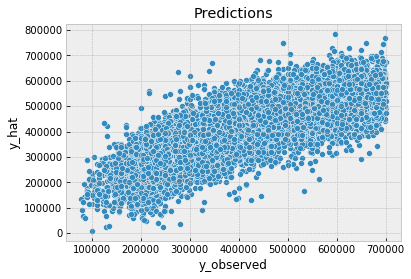

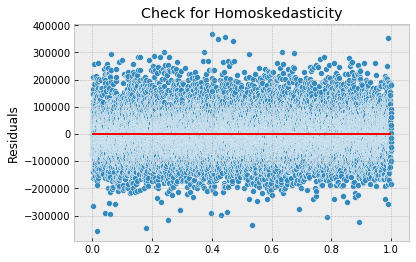

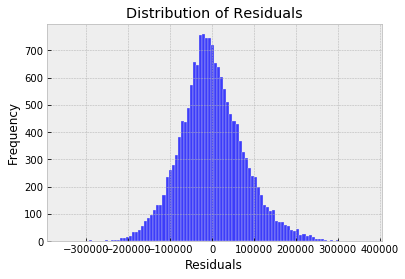

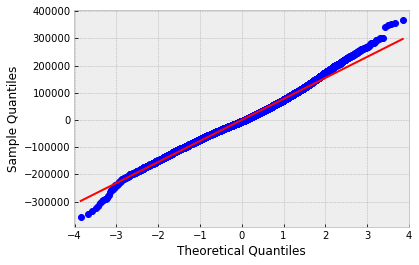

The mean of the residuals is: -5.1e-07. The closer to 0, the better.
Average error by: $ 59620.03


In [54]:
check_residuals(df_new2, target, features5, model5)

### Model 6: Interactions

We are exploring to see if it makes sense to add interactions to our model. Notably, we wonder if it makes sense to add interactions involving either floors or bathrooms as their coefficients seem relatively higher than the other features'.

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from itertools import combinations
from sklearn.model_selection import KFold

crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

In [56]:
X = df_new2.drop('price', axis=1)
y = df_new2['price']

In [57]:
regression = LinearRegression()

interactions = []

feat_combinations = combinations(X.columns, 2)


data = X.copy()


for i, (a, b) in enumerate(feat_combinations):
    data['interaction'] = data[a] * data[b]
    score = np.mean(cross_val_score(regression, data, y, scoring='r2', cv=crossvalidation))
    if score > 0.691:
        interactions.append((a, b, round(score,5)))
    
    if i % 50 == 0:
        print(i)
            
print('Top 5 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:5])

0
50
100
150
200
250
300
Top 5 interactions: [('sqft_living', 'floors', 0.69744), ('bathrooms', 'sqft_living', 0.6922), ('avg_income_zip', 'city_Federal_Way', 0.69129), ('zip_population_density', 'city_Federal_Way', 0.69129), ('bedrooms', 'floors', 0.69109)]


We see that adding interactions between sqft_living and floors and between sqft_living and bathrooms will improve our model, so let's do that.

In [58]:
#Add interactions to our model 
df_new2['sqft_living*floors'] = df_new2['sqft_living'] * df_new2['floors']
df_new2['sqft_living*bathrooms'] = df_new2['sqft_living'] * df_new2['bathrooms']

In [59]:
final_model = create_ols(df_new2, target)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     1411.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        10:02:38   Log-Likelihood:            -2.1544e+05
No. Observations:               17024   AIC:                         4.309e+05
Df Residuals:                   16995   BIC:                         4.312e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -5.55

In [60]:
features6 = list(df_new2.columns)
features6.remove(target)

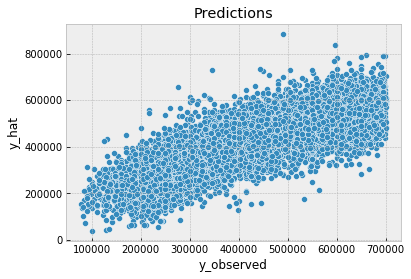

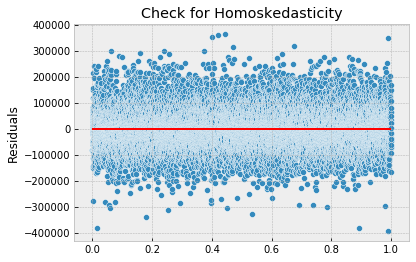

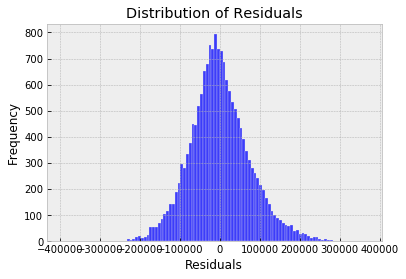

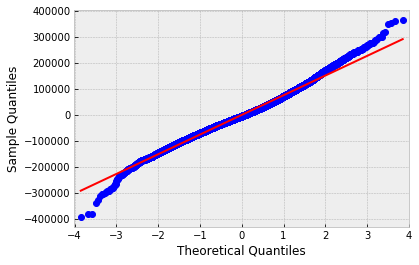

The mean of the residuals is: 1.9e-07. The closer to 0, the better.
Average error by: $ 58049.93


In [61]:
check_residuals(df_new2, target, features6, final_model)

### Final Thoughts

In [64]:
import statsmodels.graphics.factorplots as smpl

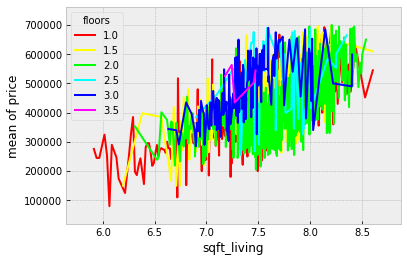

In [65]:
fig = smpl.interaction_plot(df_new2.sqft_living, df_new2.floors, df_new2.price, plottype = 'line', ms=10)

Our interactions are statistically significant, thus we know that the effect of sqft living has on price depends on the number of floors and bathrooms in the house.

### Final Model: Coefficients Interpretation

Intercept Interpretation:
- Our intercept is -5.59 has no meaningful interpretation as it’s impossible for all our feature variables to be 0. It’s just there to achnor our regression line.

A summary of our relevant coefficients are as follows:

- A one unit increase of bedrooms would decrease price by \\$11,730
- A one unit increase of bathrooms would decrease price by \\$99,240
- A one percent increase of sqft_living would increase price by \\$792
- A one unit increase of floors would decrease price by \\$543,800
- A one unit increase of view would increase price by \\$24,260
- A one unit increase of condition would increase price by \\$16,930
- The impact of whether a house is located in a certain city has a specific impact on price; as an example, if the home is located in Bellevue, in relation to Seattle (the dropped dummy term), the increase on price will be \\$47,320
- The effect of sqft_living on price is different for different values of floors; this interaction has a positive affect on price, and as floors increase by one unit, the impact of sqft_living on price will increase by \\$73,800
- The effect of sqft_living on price is different for different numbers of bathrooms; this interaction has a positive affect on price, and as bathrooms increase by one unit, the impact of sqft_living on price will increase by \\$14,760


In [63]:
df_new2.to_csv('Finaldata')